In [22]:
import os
import ast
import pandas as pd

# 'gao-2018-fhc', 
bin_data_names = ['twitter-hate-speech-tsa', 'civil-comments', 'gibert-2018-shs', 'us-election-2020', 'cmsb-tsd']
multi_class_data_names = ['founta-2018-thas', 'davidson-thon', 'ami']
eval_data_names = bin_data_names + multi_class_data_names

compare_rho_data_names = ['gao-2018-fhc', 'gao-2018-fhc_rho=5.0', 'gao-2018-fhc_rho=10.0', 'gao-2018-fhc_rho=15.0', 'gao-2018-fhc_rho=20.0',
                            'waseem-and-hovy-2016', 'waseem-and-hovy-2016_rho=5.0', 'waseem-and-hovy-2016_rho=10.0', 'waseem-and-hovy-2016_rho=15.0', 'waseem-and-hovy-2016_rho=20.0']

data_cols = ["data_name", "num_classes", "data_type", "size", "rho", "distribution"]
variant_cols = ['variant', 'sampling_modifiedRS_rho', 'sampling_weightedRS_percentage', 'augmentation_rho', 'augmentation_percentage', 'augmentation_top_k', 'wce_alpha', 'fl_gamma', "augmentation_bert_top_k"]
metric_suffices = ['f1_macro', 'f1_per_label_0', 'f1_per_label_1', 'f1_per_label_2', 'f1_per_label_3', 'f1_per_label_4', 'accuracy', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted', 'auprc']
metrics_cols = [f'train_{suffix}' for suffix in metric_suffices] + [f'val_{suffix}' for suffix in metric_suffices] + [f'test_{suffix}' for suffix in metric_suffices]
cols_raw = data_cols + variant_cols + ['pl_seed'] + metrics_cols + ["best_epoch"] + ['mlflow_run_id']

cols_seeds_mean = data_cols + variant_cols[:-1] + ['val_f1_macro', 'test_f1_macro', 'test_f1_macro_std'] + [metric for metric in metrics_cols if metric not in ['val_f1_macro', 'test_f1_macro', 'test_f1_macro_std']]

results_excel_path = "results_all.xlsx"
cols_results = data_cols + variant_cols[:-1] + ['test_f1_macro', 'test_f1_macro_std']

In [23]:
data2distribution = {}
data2size = {}
data2rho = {}

def read_from_csv(data_name, header=0, names=None):
    if "tsv" in data_name:
        data = pd.read_csv(data_name,
                            sep='\t',
                            encoding = "utf-8",
                            engine = "python",
                            header = header,
                            names = names)
    elif "csv" in data_name:
        data = pd.read_csv(data_name,
                        encoding = "utf-8",
                        engine = "python",
                        header = header,
                        names = names)
    else:
        raise NotImplementedError("Given data file type is not supported yet.")
    return data
def get_data_info_by_data_name(data_name, label_col, category2label, train_filename, val_filename=None, test_filename=None):
    data = read_from_csv(f"./data/{data_name}/{train_filename}")
    label_counts = data[label_col].value_counts()
    if val_filename:
        val_data = read_from_csv(f"./data/{data_name}/{val_filename}")
        label_counts += val_data[label_col].value_counts()
    if test_filename:
        test_data = read_from_csv(f"./data/{data_name}/{test_filename}")
        label_counts += test_data[label_col].value_counts()
    data2size[data_name] = sum(label_counts.values)
    data2distribution[data_name] = {f"{label}_{cat}": round(label_counts[label]/data2size[data_name], 3) for cat, label in category2label.items()}
    data2rho[data_name] = round(max(label_counts.values) / min(label_counts.values), 2)

# get_data_info_by_data_name("bretschneider-th-main", "label", {"neutral": 0, "harassment": 1}, "data_clean.csv")
get_data_info_by_data_name("twitter-hate-speech-tsa", "label", {"non-hate": 0, "hate": 1}, "data_clean.csv")
get_data_info_by_data_name("civil-comments", "label", {"non-toxic": 0, "toxic": 1}, "data_clean.csv")
# get_data_info_by_data_name("bretschneider-th-school", "label", {"neutral": 0, "harassment": 1}, "data_clean.csv")
get_data_info_by_data_name("gibert-2018-shs", "label", {"no-hate": 0, "hate": 1}, "data_clean.csv")
get_data_info_by_data_name("us-election-2020", "label", {"non-HOF": 0, "HOF": 1}, "train_clean.csv", test_filename="test_clean.csv")
get_data_info_by_data_name("cmsb-tsd", "label", {"non-sexist": 0, "sexist": 1}, "data_clean.csv")
get_data_info_by_data_name("waseem-and-hovy-2016", "label", {"neither": 0, "racism/sexism": 1}, "data_clean.csv")
get_data_info_by_data_name("founta-2018-thas", "label_multi", {"normal": 0, "spam": 1, "abusive": 2, "hateful": 3}, "data_clean.csv")
get_data_info_by_data_name("ami", "label_multi", {"discredit": 0, "stereotype": 1, "dominance": 2, "sexual harassment": 3, "derailing": 4}, "train_clean.csv", test_filename="test_clean.csv")
get_data_info_by_data_name("davidson-thon", "label_multi", {"hate speech": 0, "offensive language": 1, "neither": 2}, "data_clean.csv")

get_data_info_by_data_name("gao-2018-fhc", "label", {"non-hateful": 0, "hateful": 1}, "data_clean.csv")
get_data_info_by_data_name("gao-2018-fhc_rho=5.0", "label", {"non-hateful": 0, "hateful": 1}, "data_clean.csv")
get_data_info_by_data_name("gao-2018-fhc_rho=10.0", "label", {"non-hateful": 0, "hateful": 1}, "data_clean.csv")
get_data_info_by_data_name("gao-2018-fhc_rho=15.0", "label", {"non-hateful": 0, "hateful": 1}, "data_clean.csv")
get_data_info_by_data_name("gao-2018-fhc_rho=20.0", "label", {"non-hateful": 0, "hateful": 1}, "data_clean.csv")

get_data_info_by_data_name("waseem-and-hovy-2016", "label", {"neither": 0, "racism/sexism": 1}, "data_clean.csv")
get_data_info_by_data_name("waseem-and-hovy-2016_rho=5.0", "label", {"neither": 0, "racism/sexism": 1}, "data_clean.csv")
get_data_info_by_data_name("waseem-and-hovy-2016_rho=10.0", "label", {"neither": 0, "racism/sexism": 1}, "data_clean.csv")
get_data_info_by_data_name("waseem-and-hovy-2016_rho=15.0", "label", {"neither": 0, "racism/sexism": 1}, "data_clean.csv")
get_data_info_by_data_name("waseem-and-hovy-2016_rho=20.0", "label", {"neither": 0, "racism/sexism": 1}, "data_clean.csv")

data2distribution, data2size, data2rho

({'twitter-hate-speech-tsa': {'0_non-hate': 0.93, '1_hate': 0.07},
  'civil-comments': {'0_non-toxic': 0.92, '1_toxic': 0.08},
  'gibert-2018-shs': {'0_no-hate': 0.888, '1_hate': 0.112},
  'us-election-2020': {'0_non-HOF': 0.883, '1_HOF': 0.117},
  'cmsb-tsd': {'0_non-sexist': 0.867, '1_sexist': 0.133},
  'waseem-and-hovy-2016': {'0_neither': 0.735, '1_racism/sexism': 0.265},
  'founta-2018-thas': {'0_normal': 0.717,
   '1_spam': 0.163,
   '2_abusive': 0.085,
   '3_hateful': 0.035},
  'ami': {'0_discredit': 0.514,
   '1_stereotype': 0.142,
   '2_dominance': 0.121,
   '3_sexual harassment': 0.176,
   '4_derailing': 0.046},
  'davidson-thon': {'0_hate speech': 0.058,
   '1_offensive language': 0.774,
   '2_neither': 0.168},
  'gao-2018-fhc': {'0_non-hateful': 0.715, '1_hateful': 0.285},
  'gao-2018-fhc_rho=5.0': {'0_non-hateful': 0.833, '1_hateful': 0.167},
  'gao-2018-fhc_rho=10.0': {'0_non-hateful': 0.909, '1_hateful': 0.091},
  'gao-2018-fhc_rho=15.0': {'0_non-hateful': 0.937, '1_hate

In [24]:
def get_value_by_run_id(data_dir, run_id, key):
    value = None
    for root, _, files in os.walk(data_dir + run_id):
        if key in files:
            with open(f"{root}/{key}", "r") as f:
                value = f.readlines()[-1]
                if "train" in key or "val" in key or "test" in key:
                    value = value.split()[1]
                if value == "sampling_modifiedRS": # Forgot to specify in the variant value
                    value += "_oversampling"
                if value == "sampling_weightedRS":
                    value += "_combi"
                if "tensor" in value:
                    value = "-"
                try:
                    value = ast.literal_eval(value)
                    if isinstance(value, list):
                        value = [round(v, 2) for v in value]
                        value = tuple(value)
                except (ValueError, SyntaxError):
                    pass
                break
    if value is None:
        value = "-"
        if "train" in key or "val" in key or "test" in key:
            if "per_label" in key:
                value = 0
            else:
                raise RuntimeError(f"This run log {data_dir + run_id} does not have test metrics. ")
    return value

def get_best_epoch_by_run_id(data_dir, run_id):
    ckpt_dir = f"{data_dir}{run_id}/artifacts/model_checkpoints/"
    ckpt = os.listdir(ckpt_dir)[0]
    epoch = ast.literal_eval(ckpt.split("epoch=")[1][1:2])
    return epoch

def get_log_by_data_name(data_name):
    data_runs_dir = f'./logs/{data_name}/'
    run_ids = os.listdir(data_runs_dir)
    rows = []
    for run_id in run_ids:
        run_result = {col_name: get_value_by_run_id(data_runs_dir, run_id, col_name) for col_name in cols_raw[:-2]}
        run_result['best_epoch'] = get_best_epoch_by_run_id(data_runs_dir, run_id)
        run_result['mlflow_run_id'] = run_id
        rows.append(run_result)
    df = pd.DataFrame(columns=cols_raw, data=rows)
    #  - add wfl(alpha=1.0) => fl
    df.loc[(df["variant"] == "wfl") & (df["wce_alpha"] == "-"),  "variant"] = "fl" 
    #  - combine these two columns
    def fix_aug_top_k(row):
        if row["augmentation_top_k"] != "-" or row["augmentation_bert_top_k"] != "-":
            if row["augmentation_top_k"] != "-":
                return row["augmentation_top_k"]
            else:
                return row["augmentation_bert_top_k"]
        else:
            return "-"
    df["augmentation_top_k"] = df.apply(lambda row: fix_aug_top_k(row), axis=1)
    df = df.drop('augmentation_bert_top_k', axis=1)
    return df

def aggregate_results(data_name, writer):
    # Get raw mlflow logs:
    df = get_log_by_data_name(data_name)
    df.to_excel(writer, sheet_name=f"{data_name}_raw")
    assert len(df) % 3 == 0
    # Aggregate results from 3 seeds
    agg_target = {metric: 'mean' for metric in metrics_cols}
    agg_target.update({col: 'first' for col in data_cols})
    df['test_f1_macro_std'] = df.loc[:, 'test_f1_macro']
    agg_target.update({'test_f1_macro_std': 'std'})
    df_seeds_mean = df.groupby(variant_cols[:-1], as_index=False).agg(agg_target)
    #  - change metric to be 00.00
    for metric in metrics_cols + ['test_f1_macro_std']:
        df_seeds_mean[metric] = df_seeds_mean[metric].apply(lambda x: ast.literal_eval("{0:.2f}".format(x*100)))
    
    #  - re-order the columns
    df_seeds_mean.loc[:, "size"] = [data2size[data_name]] * len(df_seeds_mean)
    df_seeds_mean.loc[:, "distribution"] = [data2distribution[data_name]] * len(df_seeds_mean)
    df_seeds_mean.loc[:, "rho"] = [data2rho[data_name]] * len(df_seeds_mean)
    
    df_seeds_mean = df_seeds_mean[cols_seeds_mean]
    df_seeds_mean.to_excel(writer, sheet_name=f"{data_name}_seeds-mean")
    df_val_f1_max = df_seeds_mean.loc[df_seeds_mean.groupby(["variant"])['val_f1_macro'].idxmax()].reset_index(drop=True)
    return df, df_seeds_mean, df_val_f1_max

In [126]:
data_names = eval_data_names

writer = pd.ExcelWriter(results_excel_path)
df_all_raw_results = pd.DataFrame(columns=cols_raw)
df_all_mean_results = pd.DataFrame(columns=cols_seeds_mean)
df_all_agg_results = pd.DataFrame(columns=cols_results)
for data_name in data_names:
    print(f"Extracting logs for {data_name} ...")
    df, df_seeds_mean, df_val_f1_max = aggregate_results(data_name, writer)
    df_all_raw_results = pd.concat([df_all_raw_results, df], ignore_index=True)
    df_all_mean_results = pd.concat([df_all_mean_results, df_seeds_mean], ignore_index=True)
    df_all_agg_results = pd.concat([df_all_agg_results, df_val_f1_max], ignore_index=True)
df_all_raw_results.to_csv("results/raw_results.csv", index=False)
df_all_mean_results.to_csv("results/mean_results.csv", index=False)
df_all_agg_results = df_all_agg_results.sort_values(by=['data_name', 'test_f1_macro']).reset_index(drop=True)
df_all_agg_results.to_excel(writer, sheet_name=f"best_of_all")

variants = df_all_agg_results.variant.unique()
df_table = pd.DataFrame(columns=data_names)
for variant in variants:
    for data_name in data_names:
        condition = (df_all_agg_results["variant"] == variant) & (df_all_agg_results["data_name"] == data_name)
        if len(df_all_agg_results[condition]) > 0:
            df_table.loc[variant, data_name] = df_all_agg_results[condition]["test_f1_macro"].values[0]
df_table.to_excel(writer, sheet_name=f"Table")
writer.close()

Extracting logs for twitter-hate-speech-tsa ...


/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
/tmp/ipykernel_3995034/4088372472.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all_raw_results = pd.concat([df_all_raw_results, df], ignore_index=True)
/tmp/ipykernel_3995034/4088372472.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old beh

Extracting logs for civil-comments ...
Extracting logs for gibert-2018-shs ...
Extracting logs for us-election-2020 ...
Extracting logs for cmsb-tsd ...
Extracting logs for founta-2018-thas ...
Extracting logs for davidson-thon ...
Extracting logs for ami ...


In [127]:
df_table

,twitter-hate-speech-tsa,civil-comments,gibert-2018-shs,us-election-2020,cmsb-tsd,founta-2018-thas,davidson-thon,ami
sampling_weightedRS_combi,87.33,73.12,76.71,74.87,84.84,61.61,73.89,53.62
th,86.18,75.27,77.11,77.06,84.91,61.9,74.33,53.83
sampling_modifiedRS_undersampling,87.16,73.97,75.72,74.65,84.79,64.38,76.57,54.46
augmentation_bert,87.49,NaN,75.74,73.5,84.85,63.37,75.19,54.62
baseline,87.21,75.99,76.89,75.62,84.36,62.7,74.7,54.65
wce,87.39,73.55,75.62,77.02,84.19,64.33,75.48,55.35
wfl,87.36,73.45,76.39,74.73,84.84,64.22,75.52,55.54
augmentation_abusive_lexicon,NaN,NaN,77.25,NaN,NaN,NaN,NaN,55.61
sampling_modifiedRS_oversampling,87.65,75.85,77.25,76.23,84.83,63.98,75.64,55.7
fl,88.01,76.75,77.45,74.44,84.72,63.55,74.74,56.44


## Plot results

In [179]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
sns.set_context("paper")

In [205]:
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [31]:
data_name_orig2display = {'twitter-hate-speech-tsa': 'Twitter-Hate-Speech', 
                            'civil-comments': 'Civil-Comments', 
                            'gibert-2018-shs': 'Gibert-2018', 
                            'us-election-2020': 'US-Election-2020', 
                            'cmsb-tsd': 'CMSB', 
                            'waseem-and-hovy-2016': 'Waseem-and-Hovy-2016',
                            'founta-2018-thas': 'Founta-2018', 
                            'davidson-thon': 'Davidson-2017', 
                            'ami': 'AMI'}

### Random Oversampling: Overfitting

In [175]:
data_clear_overfitting = ["founta-2018-thas", "davidson-thon"]
which_data_to_check = (df_all_mean_results["variant"].isin(["baseline", "sampling_modifiedRS_oversampling"])) & (df_all_mean_results["data_name"].isin(data_clear_overfitting))
df_overfitting = df_all_mean_results[which_data_to_check][["data_name", "sampling_modifiedRS_rho", "train_f1_macro", "val_f1_macro", "test_f1_macro"]]
def compute_deviation_to_baseline(row, split):
    baseline_condition = (df_overfitting["data_name"] == row["data_name"]) & (df_overfitting["sampling_modifiedRS_rho"] == "-")
    baseline_value = df_overfitting.loc[baseline_condition, f"{split}_f1_macro"].values[0]
    return row[f"{split}_f1_macro"] - baseline_value
for split in ["train", "val", "test"]:
    df_overfitting[f"{split}_f1_macro_delta"] = df_overfitting.apply(lambda row: compute_deviation_to_baseline(row, split), axis=1)
df_overfitting = df_overfitting[df_overfitting["sampling_modifiedRS_rho"] != "-"]
df_overfitting = df_overfitting[["sampling_modifiedRS_rho", "data_name", "train_f1_macro_delta", "val_f1_macro_delta", "test_f1_macro_delta"]]
df_overfitting

,sampling_modifiedRS_rho,data_name,train_f1_macro_delta,val_f1_macro_delta,test_f1_macro_delta
400,1.0,founta-2018-thas,3.69,-1.69,-1.09
401,2.0,founta-2018-thas,2.43,-0.72,0.01
402,3.0,founta-2018-thas,2.11,-0.21,0.04
403,5.0,founta-2018-thas,-0.38,0.21,1.07
404,7.5,founta-2018-thas,-0.41,0.35,0.92
405,10.0,founta-2018-thas,-2.29,0.76,1.28
406,15.0,founta-2018-thas,-1.73,0.06,0.90
466,1.0,davidson-thon,5.90,0.82,0.72
467,2.0,davidson-thon,5.74,1.46,-0.19
468,3.0,davidson-thon,4.91,1.35,0.17


In [176]:
df_overfitting_expanded = pd.DataFrame(columns=["sampling_modifiedRS_rho", "data_name", "split", "f1_delta"])
rhos_unique = df_overfitting.sampling_modifiedRS_rho.unique().tolist()[:-1]
data_names_unique = df_overfitting.data_name.unique().tolist()
data_names_list = []
for data_name in data_names_unique:
    data_names_list += [data_name_orig2display[data_name]] * 3 * len(rhos_unique)
df_overfitting_expanded["data_name"] = data_names_list
rhos_list = []
for rho in rhos_unique:
    rhos_list += [rho] * 3
df_overfitting_expanded["sampling_modifiedRS_rho"] = rhos_list * len(data_names_unique)
splits = ["train", "val", "test"]
df_overfitting_expanded["split"] = splits * len(rhos_unique) * len(data_names_unique)
for data_name in data_names_unique:
    for split in splits:
        for rho in rhos_unique:
            where_to_assign = ((df_overfitting_expanded["data_name"] == data_name_orig2display[data_name]) 
                                & (df_overfitting_expanded["split"] == split)
                                & (df_overfitting_expanded["sampling_modifiedRS_rho"] == rho))
            value_from_where = ((df_overfitting["data_name"] == data_name)
                                & (df_overfitting["sampling_modifiedRS_rho"] == rho))
            if len(df_overfitting[value_from_where]) > 0:
                value = df_overfitting.loc[value_from_where, f"{split}_f1_macro_delta"].values[0]
                df_overfitting_expanded.loc[where_to_assign, "f1_delta"] = value
df_overfitting_expanded = df_overfitting_expanded.rename({"data_name":"Dataset", "split":"Split"}, axis=1)
df_overfitting_expanded

,sampling_modifiedRS_rho,Dataset,Split,f1_delta
0,1.0,Founta-2018,train,3.69
1,1.0,Founta-2018,val,-1.69
2,1.0,Founta-2018,test,-1.09
3,2.0,Founta-2018,train,2.43
4,2.0,Founta-2018,val,-0.72
5,2.0,Founta-2018,test,0.01
6,3.0,Founta-2018,train,2.11
7,3.0,Founta-2018,val,-0.21
8,3.0,Founta-2018,test,0.04
9,5.0,Founta-2018,train,-0.38


/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


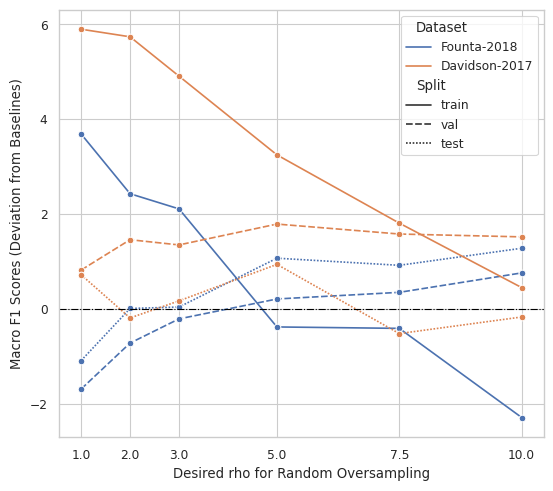

In [184]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5.625,5))
sns.lineplot(x="sampling_modifiedRS_rho", y="f1_delta", data=df_overfitting_expanded, 
                hue="Dataset", style="Split", marker="o", ax=ax)#
rho_ticks = rhos_unique
ax.set_xticks(rho_ticks, labels=rho_ticks)
ax.set_xlabel("Desired rho for Random Oversampling")
# delta_ticks = [y for y in list(range(-2, 8, 2))]
# ax.set_yticks(delta_ticks)
ax.set_ylabel("Macro F1 Scores (Deviation from Baselines)")
# '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
ax.axhline(y=0, linewidth=0.8, color="black", ls="-.")
ax.figure.tight_layout()
ax.figure.savefig('ROS_overfitting.svg', dpi=600, bbox_inches="tight")

### Weighted Cross Entropy

In [166]:
conditions = (df_all_mean_results["variant"] == "wce") & (df_all_mean_results["num_classes"] == 2)
df_mean_wce = df_all_mean_results[conditions][["data_name", "wce_alpha", "test_f1_macro", "test_f1_per_label_0", "test_f1_per_label_1"]]
def compute_deviation_to_baseline(row):
    baseline_condition = (df_all_mean_results["data_name"] == row["data_name"]) & (df_all_mean_results["variant"] == "baseline")
    baseline_value = df_all_mean_results.loc[baseline_condition, "test_f1_per_label_1"].values[0]
    return row['test_f1_per_label_1'] - baseline_value
df_mean_wce["pos_f1_delta"] = df_mean_wce.apply(lambda row: compute_deviation_to_baseline(row), axis=1)
df_mean_wce["data_name"] = df_mean_wce["data_name"].map(data_name_orig2display)
df_mean_wce

,data_name,wce_alpha,test_f1_macro,test_f1_per_label_0,test_f1_per_label_1,pos_f1_delta
29,Twitter-Hate-Speech,0.1,86.44,98.32,74.56,-1.60
30,Twitter-Hate-Speech,0.25,87.66,98.38,76.94,0.78
31,Twitter-Hate-Speech,0.75,87.39,98.30,76.47,0.31
32,Twitter-Hate-Speech,0.9,86.77,98.23,75.31,-0.85
33,Twitter-Hate-Speech,0.93,86.56,98.16,74.97,-1.19
34,Twitter-Hate-Speech,0.99,81.03,96.70,65.36,-10.80
101,Civil-Comments,0.1,74.18,96.09,52.28,-3.76
102,Civil-Comments,0.25,77.21,96.73,57.70,1.66
103,Civil-Comments,0.75,73.55,95.44,51.66,-4.38
104,Civil-Comments,0.9,75.47,95.42,55.52,-0.52


In [47]:
conditions = (df_all_mean_results["variant"] == "wce") & (df_all_mean_results["num_classes"] > 2)
df_mean_wce_multi = df_all_mean_results[conditions][["data_name", "wce_alpha", "test_f1_macro", 'test_f1_per_label_0', 'test_f1_per_label_1', 'test_f1_per_label_2', 'test_f1_per_label_3', 'test_f1_per_label_4']]
df_mean_wce_multi["data_name"] = df_mean_wce_multi["data_name"].map(data_name_orig2display)
df_mean_wce_multi

,data_name,wce_alpha,test_f1_macro,test_f1_per_label_0,test_f1_per_label_1,test_f1_per_label_2,test_f1_per_label_3,test_f1_per_label_4
397,Founta-2018,"(0.1, 0.2, 0.4, 1.0)",64.33,84.26,56.96,77.19,38.91,0.00
398,Founta-2018,"(0.1, 0.7, 0.9, 0.1)",59.83,82.37,52.69,77.87,26.38,0.00
399,Founta-2018,"(0.5, 0.6, 0.1, 0.6)",62.51,86.01,53.70,73.65,36.68,0.00
400,Founta-2018,"(0.5, 0.6, 0.2, 0.4)",63.73,86.27,54.25,78.47,35.91,0.00
401,Founta-2018,"(0.9, 0.1, 0.3, 0.7)",58.88,87.48,40.58,75.80,31.66,0.00
467,Davidson-2017,"(0.1, 0.7, 0.9)",69.45,24.88,94.65,88.82,0.00,0.00
468,Davidson-2017,"(0.5, 0.6, 0.1)",72.17,36.73,93.95,85.84,0.00,0.00
469,Davidson-2017,"(0.9, 0.1, 0.3)",75.48,44.14,93.58,88.73,0.00,0.00
470,Davidson-2017,"(1.2, 0.1, 0.4)",74.63,41.94,93.68,88.26,0.00,0.00
525,AMI,"(0.1, 0.7, 0.9, 0.1, 0.9)",55.35,64.23,84.82,47.10,53.09,27.51


In [167]:
# wce_alpha_unique = df_mean_wce.wce_alpha.unique().tolist()
wce_alpha_unique = [0.1, 0.25, 0.75, 0.867, 0.878, 0.888, 0.9, 0.99]
# data_name_unique = df_mean_wce.data_name.unique().tolist()
data_name_unique = [data_name_orig2display[data_name] for data_name in ["gibert-2018-shs", "us-election-2020", "cmsb-tsd"]]
df_wce_delta_by_data = pd.DataFrame(columns=["wce_alpha"] + sum([[f"{data_name}_macro_f1", 
                                                                    # f"{data_name}_f1_non-hate", 
                                                                    f"{data_name}_f1_hate"] for data_name in data_name_unique], []))
df_wce_delta_by_data["wce_alpha"] = wce_alpha_unique
for data_name in data_name_unique:
    for wce_alpha in wce_alpha_unique:
        conditions = (df_mean_wce["data_name"] == data_name) & (df_mean_wce["wce_alpha"] == wce_alpha)
        if len(df_mean_wce[conditions]) > 0:
            value = df_mean_wce.loc[conditions, "test_f1_macro"].values[0]
            df_wce_delta_by_data.loc[df_wce_delta_by_data["wce_alpha"] == wce_alpha, f"{data_name}_macro_f1"] = value
            # value = df_mean_wce.loc[conditions, "test_f1_per_label_0"].values[0]
            # df_wce_delta_by_data.loc[df_wce_delta_by_data["wce_alpha"] == wce_alpha, f"{data_name}_f1_non-hate"] = value
            value = df_mean_wce.loc[conditions, "test_f1_per_label_1"].values[0]
            df_wce_delta_by_data.loc[df_wce_delta_by_data["wce_alpha"] == wce_alpha, f"{data_name}_f1_hate"] = value
df_wce_delta_by_data = df_wce_delta_by_data.sort_values(by=['wce_alpha']).reset_index(drop=True)
df_wce_delta_by_data

,wce_alpha,Gibert-2018_macro_f1,Gibert-2018_f1_hate,US-Election-2020_macro_f1,US-Election-2020_f1_hate,CMSB_macro_f1,CMSB_f1_hate
0,0.100,73.52,52.36,56.42,17.69,83.54,71.56
1,0.250,75.41,56.16,74.53,53.82,84.19,72.62
2,0.750,76.44,58.7,74.95,54.83,84.83,74.02
3,0.867,NaN,NaN,NaN,NaN,84.32,73.4
4,0.878,NaN,NaN,76.55,57.63,NaN,NaN
5,0.888,75.62,56.81,NaN,NaN,NaN,NaN
6,0.900,76.57,59.2,77.02,58.88,84.17,73.03
7,0.990,74.41,56.04,29.47,28.51,80.31,67.65


### Focal Loss

In [32]:
conditions = (df_all_mean_results["variant"] == "fl") & (df_all_mean_results["num_classes"] == 2)
df_mean_fl = df_all_mean_results[conditions][["data_name", "fl_gamma", "test_f1_macro", "test_f1_per_label_0", "test_f1_per_label_1"]]
df_mean_fl["data_name"] = df_mean_fl["data_name"].map(data_name_orig2display)

fl_gamma_unique = df_mean_fl.fl_gamma.unique().tolist()
data_name_unique = df_mean_fl.data_name.unique().tolist()
df_mean_fl_by_data = pd.DataFrame()
df_mean_fl_by_data["fl_gamma"] = fl_gamma_unique
for data_name in data_name_unique:
    for fl_gamma in fl_gamma_unique:
        conditions = (df_mean_fl["data_name"] == data_name) & (df_mean_fl["fl_gamma"] == fl_gamma)
        if len(df_mean_fl[conditions]) > 0:
            value = df_mean_fl.loc[conditions, "test_f1_macro"].values[0]
            df_mean_fl_by_data.loc[df_mean_fl_by_data["fl_gamma"] == fl_gamma, f"{data_name}_macro_f1"] = value
            value = df_mean_fl.loc[conditions, "test_f1_per_label_0"].values[0]
            df_mean_fl_by_data.loc[df_mean_fl_by_data["fl_gamma"] == fl_gamma, f"{data_name}_f1_non-hate"] = value
            value = df_mean_fl.loc[conditions, "test_f1_per_label_1"].values[0]
            df_mean_fl_by_data.loc[df_mean_fl_by_data["fl_gamma"] == fl_gamma, f"{data_name}_f1_hate"] = value
df_mean_fl_by_data = df_mean_fl_by_data.sort_values(by=['fl_gamma']).reset_index(drop=True)
df_mean_fl_by_data

,fl_gamma,Twitter-Hate-Speech_macro_f1,Twitter-Hate-Speech_f1_non-hate,Twitter-Hate-Speech_f1_hate,Civil-Comments_macro_f1,Civil-Comments_f1_non-hate,Civil-Comments_f1_hate,Gibert-2018_macro_f1,Gibert-2018_f1_non-hate,Gibert-2018_f1_hate,US-Election-2020_macro_f1,US-Election-2020_f1_non-hate,US-Election-2020_f1_hate,CMSB_macro_f1,CMSB_f1_non-hate,CMSB_f1_hate
0,0.1,87.71,98.38,77.04,75.61,96.06,55.17,76.65,94.94,58.36,74.44,94.48,54.40,84.51,95.73,73.30
1,0.2,87.52,98.32,76.72,76.17,96.00,56.34,77.45,94.91,59.99,77.82,95.76,59.87,84.72,95.62,73.82
2,0.5,88.01,98.44,77.59,76.75,96.29,57.20,77.24,94.99,59.49,72.89,95.11,50.67,84.41,95.81,73.02
3,1.0,86.81,98.25,75.36,75.26,96.25,54.27,76.37,95.01,57.72,73.88,94.28,53.48,84.37,95.54,73.21
4,2.0,86.86,98.18,75.54,74.33,96.08,52.59,77.02,94.58,59.47,74.45,95.79,53.10,84.62,95.49,73.75
5,5.0,86.58,98.17,74.99,73.50,96.25,50.76,76.55,94.33,58.77,72.41,94.82,50.00,84.89,95.67,74.12


In [161]:
conditions = (df_all_mean_results["variant"] == "fl") & (df_all_mean_results["data_name"] == "founta-2018-thas")
df_mean_fl = df_all_mean_results[conditions][["data_name", "fl_gamma", "test_f1_macro", "test_f1_per_label_0", "test_f1_per_label_1", "test_f1_per_label_2", "test_f1_per_label_3"]]
df_mean_fl["data_name"] = df_mean_fl["data_name"].map(data_name_orig2display)

fl_gamma_unique = df_mean_fl.fl_gamma.unique().tolist()
data_name_unique = df_mean_fl.data_name.unique().tolist()
df_mean_fl_by_data = pd.DataFrame()
df_mean_fl_by_data["fl_gamma"] = fl_gamma_unique
for data_name in data_name_unique:
    for fl_gamma in fl_gamma_unique:
        conditions = (df_mean_fl["data_name"] == data_name) & (df_mean_fl["fl_gamma"] == fl_gamma)
        if len(df_mean_fl[conditions]) > 0:
            value = df_mean_fl.loc[conditions, "test_f1_macro"].values[0]
            df_mean_fl_by_data.loc[df_mean_fl_by_data["fl_gamma"] == fl_gamma, f"{data_name}_macro_f1"] = value
            value = df_mean_fl.loc[conditions, "test_f1_per_label_0"].values[0]
            df_mean_fl_by_data.loc[df_mean_fl_by_data["fl_gamma"] == fl_gamma, f"{data_name}_f1_per_label_0"] = value
            value = df_mean_fl.loc[conditions, "test_f1_per_label_1"].values[0]
            df_mean_fl_by_data.loc[df_mean_fl_by_data["fl_gamma"] == fl_gamma, f"{data_name}_f1_per_label_1"] = value
            value = df_mean_fl.loc[conditions, "test_f1_per_label_2"].values[0]
            df_mean_fl_by_data.loc[df_mean_fl_by_data["fl_gamma"] == fl_gamma, f"{data_name}_f1_per_label_2"] = value
            value = df_mean_fl.loc[conditions, "test_f1_per_label_3"].values[0]
            df_mean_fl_by_data.loc[df_mean_fl_by_data["fl_gamma"] == fl_gamma, f"{data_name}_f1_per_label_3"] = value
df_mean_fl_by_data = df_mean_fl_by_data.sort_values(by=['fl_gamma']).reset_index(drop=True)
df_mean_fl_by_data = df_mean_fl_by_data.rename({"data_name":"Dataset"}, axis=1)
df_mean_fl_by_data

,fl_gamma,Founta-2018_macro_f1,Founta-2018_f1_per_label_0,Founta-2018_f1_per_label_1,Founta-2018_f1_per_label_2,Founta-2018_f1_per_label_3
0,0.1,62.92,86.39,52.00,78.56,34.73
1,0.2,63.55,86.21,53.43,78.32,36.22
2,0.5,62.91,86.91,52.85,78.85,33.02
3,1.0,63.18,86.86,55.06,77.53,33.29
4,2.0,62.93,86.54,53.50,77.19,34.47
5,5.0,62.60,85.11,55.08,75.57,34.66


In [162]:
conditions = (df_all_mean_results["variant"] == "fl") & (df_all_mean_results["data_name"] == "ami")
df_mean_fl = df_all_mean_results[conditions][["data_name", "fl_gamma", "test_f1_macro", "test_f1_per_label_0", "test_f1_per_label_1", "test_f1_per_label_2", "test_f1_per_label_3", "test_f1_per_label_4"]]
df_mean_fl["data_name"] = df_mean_fl["data_name"].map(data_name_orig2display)

fl_gamma_unique = df_mean_fl.fl_gamma.unique().tolist()
data_name_unique = df_mean_fl.data_name.unique().tolist()
df_mean_fl_by_data = pd.DataFrame()
df_mean_fl_by_data["fl_gamma"] = fl_gamma_unique
for data_name in data_name_unique:
    for fl_gamma in fl_gamma_unique:
        conditions = (df_mean_fl["data_name"] == data_name) & (df_mean_fl["fl_gamma"] == fl_gamma)
        if len(df_mean_fl[conditions]) > 0:
            value = df_mean_fl.loc[conditions, "test_f1_macro"].values[0]
            df_mean_fl_by_data.loc[df_mean_fl_by_data["fl_gamma"] == fl_gamma, f"{data_name}_macro_f1"] = value
            value = df_mean_fl.loc[conditions, "test_f1_per_label_0"].values[0]
            df_mean_fl_by_data.loc[df_mean_fl_by_data["fl_gamma"] == fl_gamma, f"{data_name}_f1_per_label_0"] = value
            value = df_mean_fl.loc[conditions, "test_f1_per_label_1"].values[0]
            df_mean_fl_by_data.loc[df_mean_fl_by_data["fl_gamma"] == fl_gamma, f"{data_name}_f1_per_label_1"] = value
            value = df_mean_fl.loc[conditions, "test_f1_per_label_2"].values[0]
            df_mean_fl_by_data.loc[df_mean_fl_by_data["fl_gamma"] == fl_gamma, f"{data_name}_f1_per_label_2"] = value
            value = df_mean_fl.loc[conditions, "test_f1_per_label_3"].values[0]
            df_mean_fl_by_data.loc[df_mean_fl_by_data["fl_gamma"] == fl_gamma, f"{data_name}_f1_per_label_3"] = value
            value = df_mean_fl.loc[conditions, "test_f1_per_label_4"].values[0]
            df_mean_fl_by_data.loc[df_mean_fl_by_data["fl_gamma"] == fl_gamma, f"{data_name}_f1_per_label_4"] = value
df_mean_fl_by_data = df_mean_fl_by_data.sort_values(by=['fl_gamma']).reset_index(drop=True)
df_mean_fl_by_data = df_mean_fl_by_data.rename({"data_name":"Dataset"}, axis=1)
df_mean_fl_by_data

,fl_gamma,AMI_macro_f1,AMI_f1_per_label_0,AMI_f1_per_label_1,AMI_f1_per_label_2,AMI_f1_per_label_3,AMI_f1_per_label_4
0,0.1,54.25,65.13,85.09,45.69,52.34,23.02
1,0.2,56.44,67.06,84.39,48.82,57.32,24.63
2,0.5,54.92,65.48,85.64,46.06,55.99,21.42
3,1.0,54.10,65.83,84.61,41.61,53.95,24.52
4,2.0,51.73,64.35,78.86,39.08,56.64,19.74
5,5.0,51.47,62.79,78.41,39.32,55.54,21.31


In [92]:
conditions = (df_all_mean_results["variant"] == "wfl") & (df_all_mean_results["num_classes"] == 2)
df_mean_wfl = df_all_mean_results[conditions][["data_name", "fl_gamma", "wce_alpha", "test_f1_macro"]]
df_mean_wfl["data_name"] = df_mean_wfl["data_name"].map(data_name_orig2display)

fl_gamma_unique = df_mean_wfl.fl_gamma.unique().tolist()
wce_alpha_unique = [0.1, 0.25, 0.75, 0.9, 0.99]
data_name_unique = df_mean_wfl.data_name.unique().tolist()
df_mean_wfl_by_data = pd.DataFrame()
df_mean_wfl_by_data["fl_gamma"] = fl_gamma_unique * len(wce_alpha_unique)
df_mean_wfl_by_data["wce_alpha"] = sum([[alpha] * len(fl_gamma_unique) for alpha in wce_alpha_unique], [])
for data_name in data_name_unique:
    for fl_gamma in fl_gamma_unique:
        for wce_alpha in wce_alpha_unique:
            value_is_from_where = (df_mean_wfl["data_name"] == data_name) & (df_mean_wfl["fl_gamma"] == fl_gamma) & (df_mean_wfl["wce_alpha"] == wce_alpha)
            if len(df_mean_wfl[value_is_from_where]) > 0:
                value = df_mean_wfl.loc[value_is_from_where, "test_f1_macro"].values[0]
                where_to_assign = (df_mean_wfl_by_data["fl_gamma"] == fl_gamma) & (df_mean_wfl_by_data["wce_alpha"] == wce_alpha)
                df_mean_wfl_by_data.loc[where_to_assign, f"{data_name}_macro_f1"] = value
df_mean_wfl_by_data = df_mean_wfl_by_data.sort_values(by=['fl_gamma', 'wce_alpha']).reset_index(drop=True)
df_mean_wfl_by_data

,fl_gamma,wce_alpha,Twitter-Hate-Speech_macro_f1,Gibert-2018_macro_f1,US-Election-2020_macro_f1,CMSB_macro_f1
0,0.1,0.10,86.49,74.17,63.41,83.11
1,0.1,0.25,87.39,75.60,76.24,84.47
2,0.1,0.75,86.45,76.78,74.74,84.93
3,0.1,0.90,86.78,76.65,75.69,84.23
4,0.1,0.99,78.33,75.36,NaN,79.66
5,0.2,0.10,87.44,74.70,47.41,84.76
6,0.2,0.25,87.05,76.40,73.39,84.40
7,0.2,0.75,86.96,76.42,76.71,84.68
8,0.2,0.90,87.09,76.83,79.77,84.47
9,0.2,0.99,79.79,74.55,NaN,80.44


In [186]:
conditions = (df_all_mean_results["variant"] == "fl")
df_mean_fl = df_all_mean_results[conditions][["data_name", "fl_gamma", "test_f1_macro"]]
def compute_deviation_to_baseline(row):
    baseline_condition = (df_all_mean_results["data_name"] == row["data_name"]) & (df_all_mean_results["variant"] == "baseline")
    baseline_value = df_all_mean_results.loc[baseline_condition, "test_f1_macro"].values[0]
    return row['test_f1_macro'] - baseline_value
df_mean_fl["test_f1_macro_delta"] = df_mean_fl.apply(lambda row: compute_deviation_to_baseline(row), axis=1)
df_mean_fl["data_name"] = df_mean_fl["data_name"].map(data_name_orig2display)
df_mean_fl = df_mean_fl.rename({"data_name":"Dataset"}, axis=1)
df_mean_fl

,Dataset,fl_gamma,test_f1_macro,test_f1_macro_delta
6,Twitter-Hate-Speech,0.1,87.71,0.50
7,Twitter-Hate-Speech,0.2,87.52,0.31
8,Twitter-Hate-Speech,0.5,88.01,0.80
9,Twitter-Hate-Speech,1.0,86.81,-0.40
10,Twitter-Hate-Speech,2.0,86.86,-0.35
11,Twitter-Hate-Speech,5.0,86.58,-0.63
78,Civil-Comments,0.1,75.61,-0.38
79,Civil-Comments,0.2,76.17,0.18
80,Civil-Comments,0.5,76.75,0.76
81,Civil-Comments,1.0,75.26,-0.73


/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


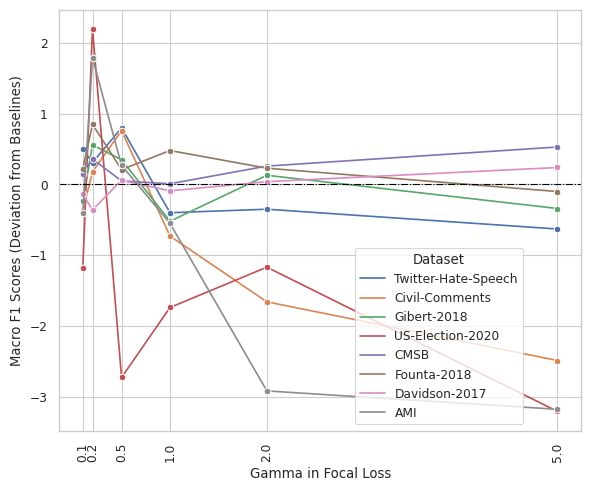

In [188]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
sns.set_context("paper")
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(6,5))
sns.lineplot(x="fl_gamma", y="test_f1_macro_delta", data=df_mean_fl, hue="Dataset", marker="o", ax=ax)
gamma_ticks = df_mean_fl.fl_gamma.unique().tolist()
ax.set_xticks(gamma_ticks, labels=gamma_ticks, rotation=90)
ax.set_xlabel("Gamma in Focal Loss")
# # delta_ticks = [y for y in list(range(-2, 8, 2))]
# # ax.set_yticks(delta_ticks)

ax.set_ylabel("Macro F1 Scores (Deviation from Baselines)")
# # '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
ax.axhline(y=0, linewidth=0.8, color="black", ls="-.")
sns.move_legend(ax, "lower right", bbox_to_anchor=(.9, 0.)) #
ax.figure.tight_layout()
ax.figure.savefig('focal_loss.svg', dpi=600, bbox_inches="tight")

#### Why are some data not good in FL?

In [24]:
# check if unpromising results in fl is because the negative class was improved
data_not_good_in_fl = ["us-election-2020", "waseem-and-hovy-2016"]
relevant_cols = ["data_name", "fl_gamma", "val_f1_macro", "test_f1_macro", 
                    "train_f1_per_label_0", "train_f1_per_label_1", 
                    "val_f1_per_label_0", "val_f1_per_label_1", 
                    "test_f1_per_label_0", "test_f1_per_label_1"]
which_row_to_check = (df_all_mean_results["variant"] == "fl") & (df_all_mean_results["data_name"].isin(data_not_good_in_fl))
df_all_mean_results[which_row_to_check][relevant_cols]

,data_name,fl_gamma,val_f1_macro,test_f1_macro,train_f1_per_label_0,train_f1_per_label_1,val_f1_per_label_0,val_f1_per_label_1,test_f1_per_label_0,test_f1_per_label_1
338,us-election-2020,0.1,81.92,74.44,99.82,98.72,95.56,68.28,94.48,54.40
339,us-election-2020,0.2,81.60,77.82,99.57,96.91,96.08,67.11,95.76,59.87
340,us-election-2020,0.5,80.13,72.89,99.66,97.57,95.77,64.49,95.11,50.67
341,us-election-2020,1.0,80.78,73.88,99.64,97.46,95.08,66.48,94.28,53.48
342,us-election-2020,2.0,77.01,74.45,99.20,94.01,95.57,58.46,95.79,53.10
343,us-election-2020,5.0,78.14,72.41,99.21,94.24,95.01,61.27,94.82,50.00
495,waseem-and-hovy-2016,0.1,86.53,86.77,99.41,98.36,92.94,80.11,93.22,80.32
496,waseem-and-hovy-2016,0.2,86.44,86.95,99.39,98.31,92.87,80.02,93.23,80.68
497,waseem-and-hovy-2016,0.5,86.16,86.50,99.33,98.16,92.46,79.85,92.75,80.25
498,waseem-and-hovy-2016,1.0,86.08,86.69,99.37,98.25,92.82,79.34,93.19,80.19


In [30]:
# check if unpromising results in fl is because the negative class was improved
data_good_in_fl = ["founta-2018-thas", "ami"]
relevant_cols = ["data_name", "fl_gamma", "val_f1_macro", "test_f1_macro", 
                    "train_f1_per_label_0", "train_f1_per_label_1", "train_f1_per_label_2", "train_f1_per_label_3", "train_f1_per_label_4",
                    "val_f1_per_label_0", "val_f1_per_label_1", "val_f1_per_label_2", "val_f1_per_label_3", "val_f1_per_label_4",
                    "test_f1_per_label_0", "test_f1_per_label_1", "test_f1_per_label_2", "test_f1_per_label_3", "test_f1_per_label_4"]
which_row_to_check = (df_all_mean_results["variant"] == "fl") & (df_all_mean_results["data_name"].isin(data_good_in_fl))
df_all_mean_results[which_row_to_check][relevant_cols]

,data_name,fl_gamma,val_f1_macro,test_f1_macro,train_f1_per_label_0,train_f1_per_label_1,train_f1_per_label_2,train_f1_per_label_3,train_f1_per_label_4,val_f1_per_label_0,val_f1_per_label_1,val_f1_per_label_2,val_f1_per_label_3,val_f1_per_label_4,test_f1_per_label_0,test_f1_per_label_1,test_f1_per_label_2,test_f1_per_label_3,test_f1_per_label_4
572,founta-2018-thas,0.1,62.30,62.92,98.47,94.16,96.66,91.46,0.00,86.55,52.49,76.89,33.27,0.00,86.39,52.00,78.56,34.73,0.00
573,founta-2018-thas,0.2,62.46,63.55,98.01,92.48,95.58,88.16,0.00,86.22,54.31,77.37,31.95,0.00,86.21,53.43,78.32,36.22,0.00
574,founta-2018-thas,0.5,62.45,62.91,97.77,91.49,95.39,87.83,0.00,86.98,53.22,77.90,31.70,0.00,86.91,52.85,78.85,33.02,0.00
575,founta-2018-thas,1.0,61.99,63.18,96.95,88.46,94.13,84.39,0.00,86.65,54.80,76.77,29.75,0.00,86.86,55.06,77.53,33.29,0.00
576,founta-2018-thas,2.0,62.28,62.93,97.24,89.33,95.27,88.20,0.00,86.54,53.85,76.73,32.00,0.00,86.54,53.50,77.19,34.47,0.00
577,founta-2018-thas,5.0,61.79,62.60,94.38,78.25,91.91,78.17,0.00,84.84,54.97,75.51,31.84,0.00,85.11,55.08,75.57,34.66,0.00
708,ami,0.1,52.93,54.25,99.56,97.64,95.85,98.99,97.56,75.64,45.58,35.45,54.40,53.60,65.13,85.09,45.69,52.34,23.02
709,ami,0.2,54.00,56.44,99.58,98.63,96.51,99.37,97.81,76.50,47.97,33.89,52.37,59.28,67.06,84.39,48.82,57.32,24.63
710,ami,0.5,52.46,54.92,99.72,99.25,98.64,99.50,100.00,76.90,48.44,35.76,51.19,50.02,65.48,85.64,46.06,55.99,21.42
711,ami,1.0,51.67,54.10,99.72,99.13,98.18,99.24,100.00,77.12,47.95,35.19,50.88,47.21,65.83,84.61,41.61,53.95,24.52


### Weighted Focal Loss

In [163]:
conditions = (df_all_mean_results["variant"] == "wfl")
df_mean_wfl = df_all_mean_results[conditions][["data_name", "wce_alpha", "fl_gamma", "test_f1_macro"]]
df_mean_wfl["data_name"] = df_mean_wfl["data_name"].map(data_name_orig2display)
df_mean_wfl

,data_name,wce_alpha,fl_gamma,test_f1_macro
35,Twitter-Hate-Speech,0.1,0.1,86.49
36,Twitter-Hate-Speech,0.1,0.2,87.44
37,Twitter-Hate-Speech,0.1,0.5,87.10
38,Twitter-Hate-Speech,0.1,1.0,87.17
39,Twitter-Hate-Speech,0.1,2.0,86.72
...,...,...,...,...
587,AMI,"(0.9, 0.1, 0.3, 0.7, 0.8)",0.2,47.61
588,AMI,"(0.9, 0.1, 0.3, 0.7, 0.8)",0.5,45.58
589,AMI,"(0.9, 0.1, 0.3, 0.7, 0.8)",1.0,46.04
590,AMI,"(0.9, 0.1, 0.3, 0.7, 0.8)",2.0,49.42


### Augmentation

In [45]:
conditions = (df_all_mean_results["variant"] == "augmentation_bert")
# data_not_good_in_fl = ["us-election-2020", "waseem-and-hovy-2016"]
relevant_cols = ["data_name", "augmentation_rho", "augmentation_percentage", "augmentation_top_k", "val_f1_macro", "test_f1_macro", 
                    "train_f1_per_label_0", "train_f1_per_label_1", 
                    "val_f1_per_label_0", "val_f1_per_label_1", 
                    "test_f1_per_label_0", "test_f1_per_label_1"]
df_mean_aug_bert = df_all_mean_results[conditions][relevant_cols]
# df_mean_aug["data_name"] = df_mean_aug["data_name"].map(data_name_orig2display)
df_mean_aug_bert

,data_name,augmentation_rho,augmentation_percentage,augmentation_top_k,val_f1_macro,test_f1_macro,train_f1_per_label_0,train_f1_per_label_1,val_f1_per_label_0,val_f1_per_label_1,test_f1_per_label_0,test_f1_per_label_1
0,bretschneider-th-main,1.5,0.1,3,77.28,69.22,97.92,97.00,96.31,58.25,94.82,43.62
1,bretschneider-th-main,1.5,0.1,5,78.15,70.57,97.99,97.11,96.87,59.42,95.35,45.79
2,bretschneider-th-main,1.5,0.3,3,74.98,65.85,97.81,96.79,95.93,54.03,93.94,37.77
3,bretschneider-th-main,1.5,0.3,5,73.44,65.99,97.68,96.62,95.82,51.06,94.29,37.69
4,bretschneider-th-main,2.0,0.1,3,76.76,69.05,97.98,96.16,96.25,57.27,94.65,43.45
...,...,...,...,...,...,...,...,...,...,...,...,...
713,ami,1.5,0.3,5,52.00,51.71,99.43,99.77,76.90,44.16,65.26,84.02
714,ami,3.0,0.1,3,53.15,54.62,99.15,99.74,78.75,41.66,66.38,82.02
715,ami,3.0,0.1,5,51.48,55.38,99.30,99.34,77.20,42.07,65.98,83.82
716,ami,3.0,0.3,3,51.20,51.68,99.39,99.34,77.68,43.04,62.22,82.47


In [54]:
df_all_mean_results[df_all_mean_results["variant"].isin(["sampling_modifiedRS_oversampling", "augmentation_external_data"])]

,data_name,num_classes,data_type,size,rho,distribution,variant,sampling_modifiedRS_rho,sampling_weightedRS_percentage,augmentation_rho,...,test_f1_per_label_1,test_f1_per_label_2,test_f1_per_label_3,test_f1_per_label_4,test_accuracy,test_precision_macro,test_precision_weighted,test_recall_macro,test_recall_weighted,test_auprc
8,bretschneider-th-main,2,bin,2898,14.66,"{'0_neutral': 0.936, '1_harassment': 0.064}",augmentation_external_data,-,-,1.0,...,30.14,0.00,0.00,0.00,87.59,59.97,91.28,66.51,87.59,58.47
9,bretschneider-th-main,2,bin,2898,14.66,"{'0_neutral': 0.936, '1_harassment': 0.064}",augmentation_external_data,-,-,1.2,...,35.22,0.00,0.00,0.00,88.68,62.13,91.96,70.03,88.68,60.35
10,bretschneider-th-main,2,bin,2898,14.66,"{'0_neutral': 0.936, '1_harassment': 0.064}",augmentation_external_data,-,-,1.5,...,31.51,0.00,0.00,0.00,87.36,60.05,91.48,68.06,87.36,59.16
18,bretschneider-th-main,2,bin,2898,14.66,"{'0_neutral': 0.936, '1_harassment': 0.064}",sampling_modifiedRS_oversampling,1.0,-,-,...,49.94,0.00,0.00,0.00,92.41,70.18,93.72,77.06,92.41,67.06
19,bretschneider-th-main,2,bin,2898,14.66,"{'0_neutral': 0.936, '1_harassment': 0.064}",sampling_modifiedRS_oversampling,1.2,-,-,...,47.78,0.00,0.00,0.00,92.59,70.11,93.36,74.21,92.59,66.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,ami,5,multi,2245,11.21,"{'0_discredit': 0.514, '1_stereotype': 0.142, ...",sampling_modifiedRS_oversampling,1.5,-,-,...,86.69,42.01,49.83,25.82,64.13,59.05,68.73,55.57,64.13,56.60
728,ami,5,multi,2245,11.21,"{'0_discredit': 0.514, '1_stereotype': 0.142, ...",sampling_modifiedRS_oversampling,2.0,-,-,...,76.84,44.50,55.69,31.75,61.88,62.39,68.23,55.29,61.88,56.59
729,ami,5,multi,2245,11.21,"{'0_discredit': 0.514, '1_stereotype': 0.142, ...",sampling_modifiedRS_oversampling,3.0,-,-,...,84.46,45.08,55.18,28.04,65.07,58.58,67.51,57.03,65.07,57.98
730,ami,5,multi,2245,11.21,"{'0_discredit': 0.514, '1_stereotype': 0.142, ...",sampling_modifiedRS_oversampling,5.0,-,-,...,82.67,46.23,56.15,26.08,64.35,59.20,67.42,55.95,64.35,57.43


In [57]:
df_all_mean_results.sampling_modifiedRS_rho.unique()

array(['-', 1.0, 1.2, 1.5, 2.0, 3.0, 5.0, 7.5, 10.0, 2.5, 15.0],
      dtype=object)

In [62]:
df_all_mean_results.augmentation_rho.unique()

array([1.5, 2.0, 1.0, 1.2, '-', 3.0, 5.0, 7.5, 10.0], dtype=object)

In [75]:
data_to_check = data_names[:-1]
conditions = (df_all_mean_results["variant"].isin(["sampling_modifiedRS_oversampling", "augmentation_external_data"]) 
                & df_all_mean_results["data_name"].isin(data_to_check))
relevant_cols = ["data_name", "variant", "sampling_modifiedRS_rho", "augmentation_rho", "val_f1_macro", "test_f1_macro", 
                    "train_f1_per_label_0", "train_f1_per_label_1", 
                    "val_f1_per_label_0", "val_f1_per_label_1", 
                    "test_f1_per_label_0", "test_f1_per_label_1"]
df_mean_aug_ext = df_all_mean_results[conditions][relevant_cols]
def get_rho(row):
    if row["sampling_modifiedRS_rho"] != "-":
        return row["sampling_modifiedRS_rho"]
    if row["augmentation_rho"] != "-":
        return row["augmentation_rho"]
df_mean_aug_ext["rho"] = df_mean_aug_ext.apply(lambda row: get_rho(row), axis=1)
df_mean_aug_ext["data_name"] = df_mean_aug_ext["data_name"].map(data_name_orig2display)
df_mean_aug_ext = df_mean_aug_ext[["data_name", "variant", "rho"] + relevant_cols[4:]]
df_mean_aug_ext = df_mean_aug_ext.sort_values(by=['data_name', 'rho']).reset_index(drop=True)
df_mean_aug_ext.to_csv("check_external_data.csv", index=False)

## Check MLflow runs

In [7]:
mlrun_ids = []

with open("./outputs/ami_augmentation_abusive_lexicon_seed0_output.txt", "r") as f:
    log_contents = f.readlines()
    mlrun_ids += [log.split("/")[-1][:-2] for log in log_contents if "MLflow Saved Child Search" in log]

# with open("./outputs/twitter-hate-speech-tsa_sampling_weightedRS_oversampling_seed21_output.txt", "r") as f:
#     log_contents = f.readlines()
#     mlrun_ids += [log.split("/")[-1][:-2] for log in log_contents if "MLflow Saved Child Search" in log]

with open("./outputs/ami_augmentation_abusive_lexicon_seed42_output.txt", "r") as f:
    log_contents = f.readlines()
    mlrun_ids += [log.split("/")[-1][:-2] for log in log_contents if "MLflow Saved Child Search" in log]
    
# with open("./outputs/ami/ami_augmentation_bert_seed0_output.txt", "r") as f:
#     log_contents = f.readlines()
#     mlrun_ids += [log.split("/")[-1][:-2] for log in log_contents if "MLflow Saved Child Search" in log]

for id in mlrun_ids:
    print(id)

len(mlrun_ids)

95b62213019e429b95401cfbaf95ad82
51d89e5446aa449893836e17d8a1646d
fc4efdeece3440ec83539724e2128b27
6895923f717f4ea8a809ca462508b59d
035f8cdd576c452483a9a5fc43363ea3
d37bccd0bb5b4a4baee077cc198f4788
457b00342f9a4247ab11afcccf386503
b95b18a0d16142a79c763035c2a7afee
8d4f81e47bcf4e369af8ffe4c438c263
511b1eb539af456cbda9a2a0eefcef00
a0bda7ad952a4782825be9c3869e908d
8c22c7071b7c434492309051cbb8eb24
9980d0788dab482eb1bcef10801ab995
076cf4f6108245d5863bed2356a54224
6cf044c161294bab83b3d1be5f67a83d
5c1cf505616f488386c0280089edc790
e1ff9982e67f410195383b528d2a05b5
82789a606cc14f109410815543aab1d1
21211cded14f4a64b5e2fb0116bed0f8
5f439288fbcf437cafa9bb248c075640
7e087ef5c5084b7d9222372e9c381536
fa25e76ae15242ed8fa68bf7b99802c7
99e1bf7c9d574c82b5e0adca3f48464f
d1f2534a0e524ee89eab1d6ceea244ee
a72bf4db2a15413681d3f1fdc2ada3c5
ea79b29ca6974f98bcd0664e62eee628
a04b6d330aeb4c2dafe1ca0e8aacb989
391ef483160345ba869da44d62c2c2cb
af3f1a22374946049a292c09c93489b1
6e2c8a2249d14f2b840ff7b81cc3ecdd
a4782c3699

56

In [130]:
ignored_ids = []

import os
data_runs_dir = f'./logs/us-election-2020'
run_ids = os.listdir(data_runs_dir)
logs = dict()
for run_id in run_ids:
    if run_id not in ignored_ids:
        ckpt_dir = f"{data_runs_dir}/{run_id}/artifacts/model_checkpoints/"
        try:
            ckpt = os.listdir(ckpt_dir)[0]
                # # print(f"{run_id}")
            if "external" in ckpt:
            #     for root, _, files in os.walk(f"{data_runs_dir}/{run_id}"):
            #         key = "augmentation_rho"
            #         if key in files:
            #             with open(f"{root}/{key}", "r") as f:
            #                 value = f.readlines()[-1]
            #                 # print(f"{key} = {value}")
            #             key = "augmentation_percentage"
            #             if key in files:
            #                 with open(f"{root}/{key}", "r") as f:
            #                     value = f.readlines()[-1]
            #                     # print(f"{key}={value}")
            #                     if value == "0.5":
            #                         print(run_id)
            #             key = "augmentation_bert_top_k"
            #             if key in files:
            #                 with open(f"{root}/{key}", "r") as f:
            #                     value = f.readlines()[-1]
            #                     # print(f"{key}={value}")
            #                     if value == "1":
            #                         print(run_id)
                print(f"{run_id}")
                logs[run_id] = ckpt
        except NotADirectoryError:
            pass
# print(logs)
len(logs)

4cd44431079f4bbdb7687cc21c349108
654e7291fbfa4b258d3d5838abb56534
8fe3be8e86114b23806291ac0a9cd1fb


3

In [80]:
logs

{'5c277ef03b1c4233ac1624a2c35f0c8f': 'gibert-2018-shs-augmentation_bert-Trial_20-seed0-epoch=00-val_f1_macro=0.76.ckpt',
 'e7447ea0f7e947b5ab1514540ff36462': 'gibert-2018-shs-augmentation_bert-Trial_5augmentation_percentage=0.3augmentation_top_k=5-seed21-epoch=00-val_f1_macro=0.76.ckpt',
 'c42acf1f44d74969a6a1d67c7597dacb': 'gibert-2018-shs-augmentation_bert-Trial_3augmentation_percentage=0.3augmentation_top_k=5-seed42-epoch=02-val_f1_macro=0.76.ckpt',
 'f7a7301c977b47189676858260a95060': 'gibert-2018-shs-augmentation_bert-Trial_0augmentation_percentage=0.3augmentation_top_k=3-seed21-epoch=02-val_f1_macro=0.77.ckpt',
 '2bf14c0e8ebc443d973edd81a31aa281': 'gibert-2018-shs-augmentation_bert-Trial_8augmentation_percentage=0.1augmentation_top_k=3-seed21-epoch=01-val_f1_macro=0.77.ckpt',
 'da64d5fc8b1c4df8a46fb154de601248': 'gibert-2018-shs-augmentation_bert-Trial_9augmentation_percentage=0.3augmentation_top_k=3-seed21-epoch=01-val_f1_macro=0.78.ckpt',
 'e99b5cae9beb4e6f9f64ac7226dcc133': 'g

In [39]:
("a", 1) in [("a", 1), ("b", 2)]

True

In [28]:
import ast
ckpt = "davidson-thon-augmentation_bert-Trial_6augmentation_percentage=0.3augmentation_top_k=3-seed42-epoch=00-val_f1_macro=0.72.ckpt"
ast.literal_eval(ckpt.split("epoch=")[1][:2])

0